# Instruction
You will need 2 new onda environment to run this notebook. One tf2 and another tflite_convert. Check out the requirements.txt files for installing dependencies for these environments.
Below need to be run from conda env tf2, which has correct tensorflow version.

First, download the BodyPix tfjs models from  URLs. For example, bodypix MobilenetV1 float32 model can be found in below link. There are other quantized models and ResNet models available but this notebook will work for float models only. However, this notebook can be changed slightly for working with quantized models.
Model at

https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/075/model-stride16.json

weights at

https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/075/group1-shard1of2.bin

https://storage.googleapis.com/tfjs-models/savedmodel/bodypix/mobilenet/float/075/group1-shard2of2.bin

Create a new directory and save them in that directory. This directory will be the root directory. set this directory as CONVERT_HOME in below environment variable.


In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import math
import tfjs_graph_converter.api as api
import os

In [ ]:
CONVERT_HOME="D:\gcloud_projects\convert"

In [ ]:
os.makedirs(CONVERT_HOME+"\\saved_model\\original")
os.makedirs(CONVERT_HOME+"\\saved_model\\converted")
os.makedirs(CONVERT_HOME+"\\tflite\\original")
os.makedirs(CONVERT_HOME+"\\tflite\\converted")

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
def graph_model_to_saved_model(model_dir,export_dir,tags):
    """
    Convert a TFJS graph model to a SavedModel
    Args:
        model_dir: Directory that contains the TFJS JSON model and weights
        export_dir: Target directory to save the TF model in
        tags: Tags for the SavedModel
    Returns:
        The path to which the model was written.
    """
    graph = api.load_graph_model(model_dir)
    signatures=tf.compat.v1.saved_model.predict_signature_def({"input":graph.get_tensor_by_name('sub_2:0')},{"shortOffsets":graph.get_tensor_by_name("float_short_offsets:0"),"segments":graph.get_tensor_by_name("float_segments:0"),"partHeatmaps":graph.get_tensor_by_name("float_part_heatmaps:0"),"longOffsets":graph.get_tensor_by_name("float_long_offsets:0"),"heatmaps":graph.get_tensor_by_name("float_heatmaps:0"),"displacement_fwd":graph.get_tensor_by_name("MobilenetV1/displacement_fwd_2/BiasAdd:0"),"displacement_bwd":graph.get_tensor_by_name("MobilenetV1/displacement_bwd_2/BiasAdd:0"),"partOffsets":graph.get_tensor_by_name("float_part_offsets:0")})
    builder = tf.compat.v1.saved_model.Builder(export_dir)

    with tf.compat.v1.Session(graph=graph) as sess:
        builder.add_meta_graph_and_variables(sess, tags=tags,signature_def_map={"predict":signatures})
    return builder.save()

This saves the saved_model to original directory. This is the saved_model version of original(or base) bodypix graph model.

In [ ]:
graph_model_to_saved_model(CONVERT_HOME,CONVERT_HOME+"\\saved_model\\original",["serve"])

# Instruction
Now that we have converted the tfjs model to saved model, log out of jupyter notebook, deactivate tf2 env and activate tflite_convert. This has the new experimental converter for tflite which supports unknown dimention in night;ly build of tensorflow. open this jupyter notebook and run below cells.

In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import math

In [3]:
CONVERT_HOME="D:\gcloud_projects\covert"

Below script saves the original bodypix model as tflite. However, this does not do any preprocessing or post processing. if you use this tflite file, all processing will have to be done in android/iOS which is cumbersome task. So, i have reimplemented the bodypix preprocessing and postprocessing inside the new model itself. This is called converted model. This model takes in image(no preprocessing required), image size, resolution, stride and threshold as input and produces segmentation, body parts etc masks. If you use this model, no preprocessing is required(if your image is too big, i suggest you resize in mobile to avoid crash) and probably much faster than implementing preprocessing in java.

This below scripts converts original model to tflite

In [ ]:
tlite=tf.lite.TFLiteConverter.from_saved_model(CONVERT_HOME+"\\saved_model\\original",signature_keys=["predict"])

In [ ]:
tlite.experimental_new_converter

In [ ]:
model_tlite=tlite.convert()

In [ ]:
with tf.io.gfile.GFile(CONVERT_HOME+"\\tflite\\original\\original_model_tlite.tflite", 'wb') as f:
  f.write(model_tlite)

Below scripts implements bodypix MobileNetV1 preprocessing and postprocessing logic inside tflite model itself.

In [ ]:
def to_valid_input_resolution(in_resolution,out_stride):
    return (in_resolution - 1.) % out_stride == 0.

In [ ]:
def  toValidInputResolution(in_resolution,out_stride):
    if(to_valid_input_resolution(in_resolution,out_stride)):
        return in_resolution
    return tf.math.floor(in_resolution / out_stride) * out_stride + 1.   

In [ ]:
def  toInputResolutionHeightAndWidth(image_height,image_width,internal_resolution=0.75,out_stride=16):
    return (toValidInputResolution(internal_resolution*image_height,out_stride),toValidInputResolution(internal_resolution*image_width,out_stride))

In [ ]:
def padAndResizeTo(input_tensor,image_height,image_width,target_height,target_width):
    targetAspect = target_width/target_height
    print("targetAspect: {targetAspect}".format(targetAspect=targetAspect))

    aspect=image_width/image_height
    print("aspect: {aspect}".format(aspect=aspect))

    (padT, padB, padL, padR) = (0, 0, 0, 0)
    
    if aspect< targetAspect:
        padT = 0
        padB = 0
        padL = tf.cast(tf.round(0.5 * (targetAspect * image_height - image_width)),tf.int32)
        padR = tf.cast(tf.round(0.5 * (targetAspect * image_height - image_width)),tf.int32)
    else:
        padT = tf.cast(tf.round(0.5 * ((1 / targetAspect) * image_width - image_height)),tf.int32)
        padB = tf.cast(tf.round(0.5 * ((1 / targetAspect) * image_width - image_height)),tf.int32)
        padL = 0
        padR = 0
    paddings=tf.convert_to_tensor([[padT, padB], [padL, padR], [0, 0]],dtype=tf.int32)
    paddedTensor = tf.pad(input_tensor,paddings)
    targetSize=tf.convert_to_tensor([target_height,target_width],dtype=tf.int32)
    paddedTensor=tf.image.resize(paddedTensor,targetSize,method=tf.image.ResizeMethod.BILINEAR)
    return {"paddedTensor":paddedTensor,"paddings":paddings}

In [ ]:
def removePaddingAndResizeBack(paddedSizedTensor,input_image_size,padding):
    padT=tf.cast(padding[0][0],tf.float32)
    padB=tf.cast(padding[0][1],tf.float32)
    padL=tf.cast(padding[1][0],tf.float32)
    padR=tf.cast(padding[1][1],tf.float32)

    #Can simplyfy this
    y1=tf.math.divide(padT,tf.math.subtract(tf.math.add(tf.math.add(input_image_size[0],padT),padB),1))
    x1=tf.math.divide(padL,tf.math.subtract(tf.math.add(tf.math.add(input_image_size[1],padL),padR),1))
    y2= tf.math.divide(tf.math.subtract(tf.math.add(padT,input_image_size[0]),1) , tf.math.subtract(tf.add(tf.math.add(input_image_size[0],padT),padB),1))
    x2=tf.math.divide(tf.math.subtract(tf.math.add(padL,input_image_size[1]),1) , tf.math.subtract(tf.math.add(tf.math.add(input_image_size[1],padL),padR),1))

    return tf.image.crop_and_resize(paddedSizedTensor,[[y1,x1,y2,x2]],[0],[input_image_size[0], input_image_size[1]])

In [ ]:
def scaleAndCropToInputTensorShape(segmentLogits,input_image_size,target_image_size,padding,applySigmoid):
    paddedSizedTensor=tf.image.resize(segmentLogits,tf.cast(target_image_size,tf.int32),method=tf.image.ResizeMethod.BILINEAR)
    if(applySigmoid):
        paddedSizedTensor=tf.math.sigmoid(paddedSizedTensor)
    print("paddedSizedTensor: {paddedSizedTensor}".format(paddedSizedTensor=paddedSizedTensor))
    return removePaddingAndResizeBack(paddedSizedTensor,input_image_size,padding)

In [ ]:
def toMaskTensor(scaledSegmentScores,threshold,image_size):
    scaledSegmentScores=tf.squeeze(scaledSegmentScores)
    scaledSegmentScores=tf.reshape(scaledSegmentScores,[image_size[0],image_size[1]])
    return tf.cast(tf.math.greater(scaledSegmentScores,threshold),tf.int32)

In [ ]:
def toFlattenedOneHotPartMap(scaledPartSegmentationScores,numParts):
    print("numParts int toFlattenedOneHotPartMap: {numParts}".format(numParts=numParts))
    partMapLocations=tf.argmax(scaledPartSegmentationScores,axis=2,output_type=tf.int32)
    partMapFlattened = tf.reshape(partMapLocations,[-1])
    print("partMapFlattened: {partMapFlattened}".format(partMapFlattened=partMapFlattened))
    return tf.one_hot(partMapFlattened,numParts,dtype=tf.int32)

In [ ]:
def decodeOnlyPartSegmentation(scaledPartSegmentationScores,image_size):
    numParts=scaledPartSegmentationScores.shape[-1]
    scaledPartSegmentationScores=tf.squeeze(scaledPartSegmentationScores)    
    flattenedMap = toFlattenedOneHotPartMap(scaledPartSegmentationScores,numParts)
    partNumbers = tf.expand_dims(tf.range(0,numParts,1,tf.int32),1)
    partMapFlattened = tf.matmul(flattenedMap,partNumbers)
    print("partMapFlattened: {partMapFlattened}".format(partMapFlattened=partMapFlattened))
    return tf.reshape(partMapFlattened,tf.cast(image_size,tf.int32))

In [ ]:
class MobileNetV1(tf.Module):
  @tf.function(input_signature=[tf.TensorSpec(shape=(None,None,3),dtype=tf.float32),tf.TensorSpec(shape=(2,),dtype=tf.float32),tf.TensorSpec(shape=(3,),dtype=tf.float32)])
  def run_body_pix(self,image,image_size,config):
    model=tf.saved_model.load(CONVERT_HOME+"\\saved_model\\original")
    (target_height,target_width)=toInputResolutionHeightAndWidth(image_size[0],image_size[1],config[0],config[1])
    print("target_height: {target_height}".format(target_height=target_height))
    print("target_width: {target_width}".format(target_width=target_width))
    afterPadding=padAndResizeTo(image,image_size[0],image_size[1],target_height,target_width)
    print("afterPadding: {afterPadding}".format(afterPadding=afterPadding))
    normalizedTensor=tf.math.subtract(tf.math.divide(afterPadding["paddedTensor"],127.0),1.0)
    print("normalizedTensor: {normalizedTensor}".format(normalizedTensor=normalizedTensor))
    out_t=model.signatures['predict'](tf.expand_dims(normalizedTensor,0))
    scaledSegmentScores=scaleAndCropToInputTensorShape(out_t["segments"],image_size,(target_height,target_width),afterPadding["paddings"],True)
    segmentation=toMaskTensor(scaledSegmentScores,config[2],image_size)
    scaledPartSegmentationScores=scaleAndCropToInputTensorShape(out_t["partHeatmaps"],image_size,(target_height,target_width),afterPadding["paddings"],True)
    partSegmentation= decodeOnlyPartSegmentation(scaledPartSegmentationScores,image_size)
    print("partSegmentation: {partSegmentation}".format(partSegmentation=tf.cast(partSegmentation,tf.uint8)))
    print("segmentation: {segmentation}".format(segmentation=segmentation))
    
    """
    I am not using pose, so not returning tensors used to calculate pose. If you need this, just use the uncomment the return here.
    But remember that the shape of these tensor depends on input shape. In tensorflowlite java, shapes are not dynamically tracked.
    You will need to calculate manually before you allocate BteBuffer.
    
    """
    #return {"segmentation":segmentation,"partSegmentation":partSegmentation,"shortOffsets":out_t["shortOffsets"],"longOffsets":out_t["longOffsets"],"heatmaps":out_t["heatmaps"],"displacement_fwd":out_t["displacement_fwd"],"displacement_bwd":out_t["displacement_bwd"],"partOffsets":out_t["partOffsets"]}
    return {"segmentation":tf.cast(segmentation,tf.uint8),"partSegmentation":tf.cast(partSegmentation,tf.uint8)}


In [ ]:
to_export=MobileNetV1()

In [ ]:
tf.saved_model.save(to_export, CONVERT_HOME+"\\saved_model\\converted",signatures=to_export.run_body_pix.get_concrete_function())

Now, we will test the converted model to see how it works.

In [2]:
import tensorflow as tf
import PIL as pil
import numpy as np
import matplotlib.pyplot as plt

In [4]:
model_converted=tf.saved_model.load(CONVERT_HOME+"\\saved_model\\converted")

In [5]:
model_converted.run_body_pix.pretty_printed_concrete_signatures()

"restored_function_body(image, image_size, config)\n  Args:\n    image: float32 Tensor, shape=(None, None, 3)\n    image_size: float32 Tensor, shape=(2,)\n    config: float32 Tensor, shape=(3,)\n  Returns:\n    {'partSegmentation': <1>, 'segmentation': <2>}\n      <1>: uint8 Tensor, shape=(None, None)\n      <2>: uint8 Tensor, shape=(None, None)"

In [6]:
image=pil.Image.open("D:\\gcloud_projects\\flutterapp\\body_pix\\converter_example\\test.JPG")

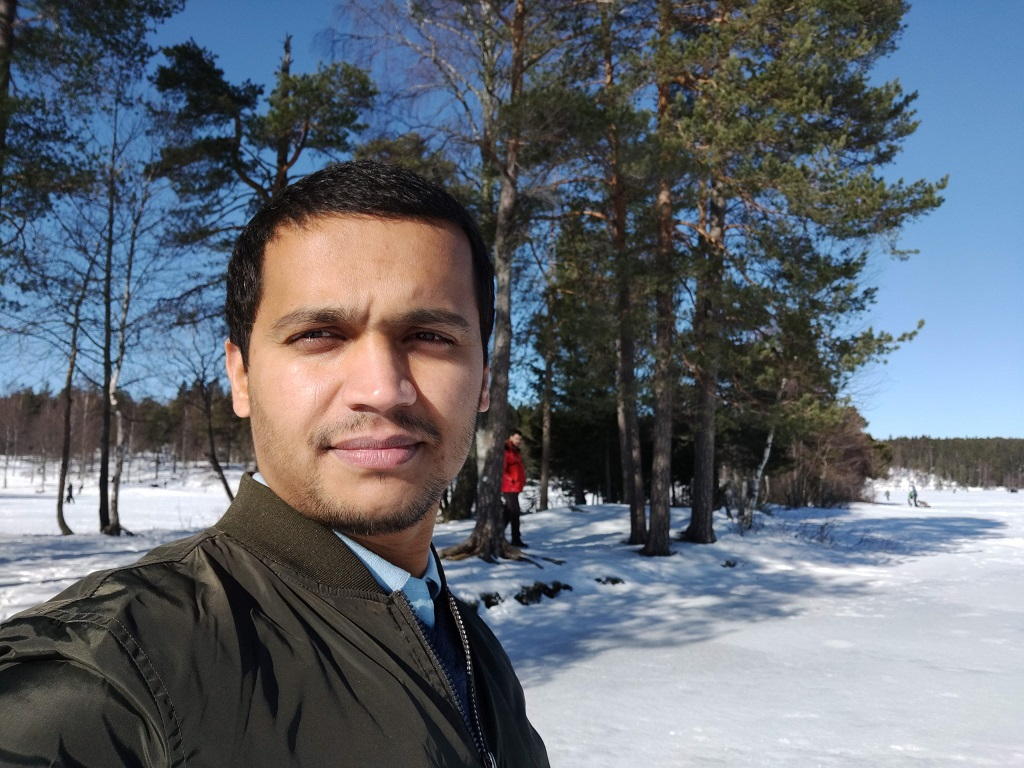

In [7]:
image

In [8]:
image=np.array(image)

Inference of the model. Play with config parameter(config[0]=internal resolution 0.25 to 2, config[1]=stride can be 8,16,32 and config[2]=confidence filter, can be 0 to 1. Higher the value more accurate pixel prediction but less accurate visual)

In [9]:
result=model_converted.signatures['serving_default'](image=tf.constant(image,dtype=tf.float32),image_size=tf.constant([image.shape[0],image.shape[1]],dtype=tf.float32),config=tf.constant([0.5,8.0,0.5]))

In [10]:
seg=result["segmentation"].numpy()

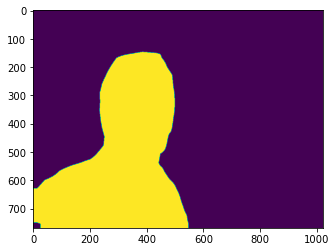

In [11]:
plt.imshow(seg)

In [12]:
parts=result["partSegmentation"].numpy()

In [13]:
np.unique(parts)

array([ 0,  1,  2,  3,  4,  5,  9, 10, 12, 13, 14, 18, 20, 22, 23],
      dtype=uint8)

In [14]:
mask=np.where(parts==1,1,0)

In [15]:
mask[seg==0]=0

In [16]:
copy_image=image.copy()

In [17]:
copy_image[np.where(mask==1)]=0

In [18]:
im=pil.Image.fromarray(copy_image)

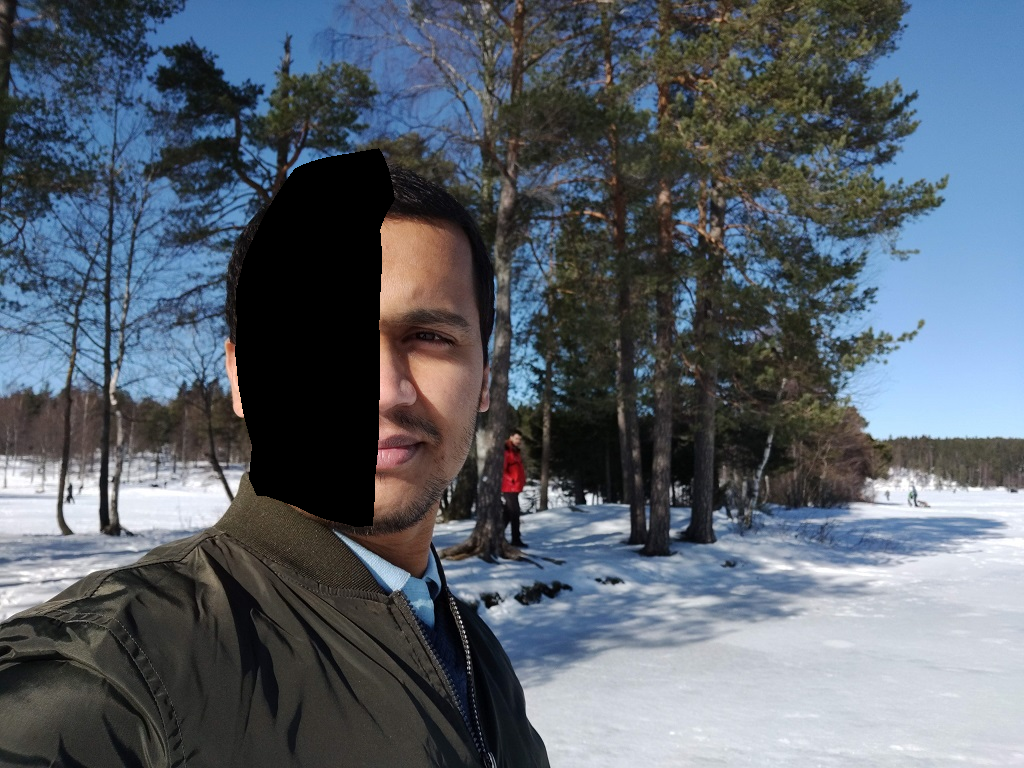

In [19]:
im

In [20]:
tlite=tf.lite.TFLiteConverter.from_saved_model(CONVERT_HOME+"\\saved_model\\converted")

In [21]:
tlite.target_spec.supported_ops = [tf.lite.OpsSet.SELECT_TF_OPS]

In [22]:
model_tlite=tlite.convert()

In [23]:
with tf.io.gfile.GFile(CONVERT_HOME+"\\tflite\\converted\\model_tlite.tflite", 'wb') as f:
  f.write(model_tlite)

# Note
the generated tflite model will not work with python interpretor because it has ops which are not supported by python interpretor. However, it should work in android/iOS if you use FlexDelegate. This below code is useful to see input/output of the model.

In [ ]:
interpreter=tf.lite.Interpreter(CONVERT_HOME+"\\tflite\\converted\\model_tlite.tflite")

In [ ]:
input_details=interpreter.get_input_details()

In [ ]:
input_details

In [ ]:
output_details=interpreter.get_output_details()

In [ ]:
output_details